In [ ]:
!pip install -q torch torchvision altair seaborn tqdm
# !git clone -q https://github.com/afspies/icl_dl_cw2_utils
# from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.3 MB/s eta 0:00:00


Initialise workspace

In [ ]:
# Initialization Cell
WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = 'joa123' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    repo_path = 'GLOW/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/{repo_path}' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw2/' # You may want to change this
    data_path = f'/vol/bitbucket/{USERNAME}/dl/'
    # Your python env and training data should be on bitbucket
    if 'vol/bitbucket' not in content_path or 'vol/bitbucket' not in data_path:
        import warnings
        warnings.warn(
           'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
           )
elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks/'
    data_path = './data/'

elif WORKING_ENV == 'SAGEMAKER':
    content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/'
    data_path = f'{content_path}data/'

else:
  raise NotImplementedError()

content_path = Path(content_path)

Mounted at /content/drive/


# Load Dataset

## Import Data

Set Hyperparameters

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'GLOW/'):
    os.makedirs(content_path/'GLOW/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


In [ ]:


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# Necessary Hyperparameters
num_epochs = 1
learning_rate = 5e-5
batch_size = 64

# Additional Hyperparameters
hidden_dim = 64

## CIFAR10

In [ ]:

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## ImageNet

In [ ]:
# trainset = torchvision.datasets.ImageNet(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.ImageNet(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)


## Large Scale Scene Understanding (LSUN)

In [ ]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
trainset = datasets.LSUN(root='./data', classes='train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.LSUN(root='./data', classes='test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Error: data/bedroom_train_lmdb: No such file or directory

## CelebA

In [ ]:
trainset = datasets.CelebA(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

## Preprocess data

In [ ]:
def mse(x, x_hat):
  '''
  x, x_hat (tensor)
  '''
  return ((x_hat-x)**2).mean()

torch.Size([64, 3, 32, 32])
tensor(-0.7176) tensor(0.9373)


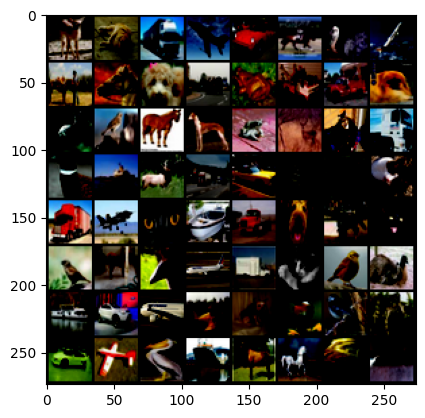

In [ ]:

# functions to show an image


def denorm(img):
    img = img / 2 + 0.5
    return img


# get some random training images
dataiter = iter(trainloader)
images, _ = next(dataiter)

print(images.shape)
print(images[0].min(), images[0].max())

# show images
show(make_grid(images))

# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

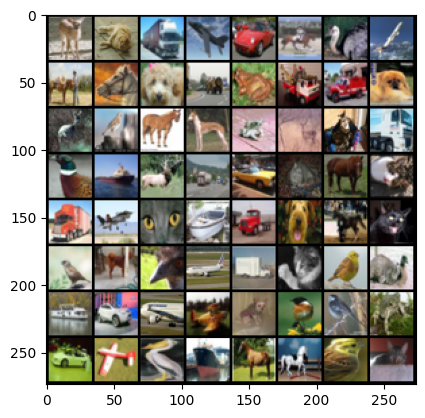

In [ ]:
show(utils.make_grid(denorm(images)))

# Neural Network

## Model Architecture

### Components

### Actnorm

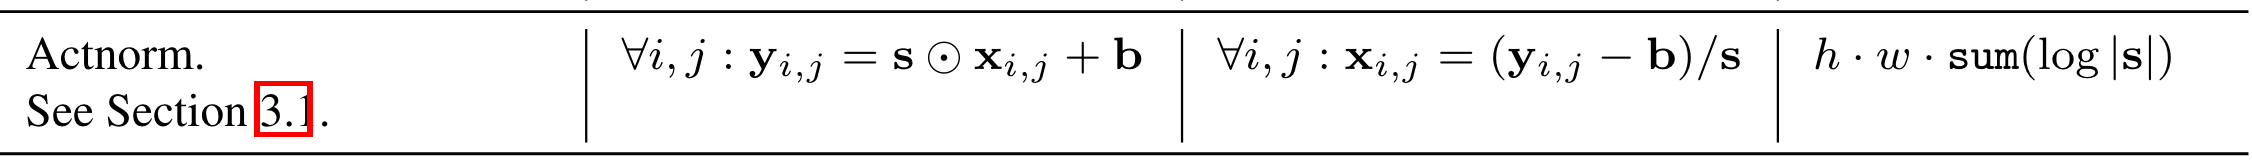

In [ ]:
class ActNorm(nn.Module):
  def __init__(self, num_channels, height, width):
    super(ActNorm, self).__init__()
    #learn logscale for stability
    # Per channel scale and bias parameter
    self.bias = nn.Parameter(torch.zeros(1, num_channels, 1, 1), requires_grad=True )
    self.log_scale = nn.Parameter(torch.zeros(1, num_channels, 1, 1), requires_grad=True)
    self.initialised = False
    self.h = height
    self.w = width

  def forward(self, x):
    # Initialised so that first minibatch has mean 0 and var 1
    if not self.initialised:
      self.bias.data = -torch.mean(x, (0,2,3), keepdim=True)
      self.log_scale.data = -torch.log(torch.std(x, (0,2,3), keepdim=True))
      self.initialised=True

    return (x * torch.exp(self.log_scale)) + self.bias, self.h * self.w * self.log_scale.sum()

  def inverse(self, z):
    return (z  - self.bias) * torch.exp(-self.log_scale)





In [ ]:
actnorm = ActNorm(3,4,4)

batch = torch.randn(1,3,4,4)

with torch.no_grad():
  a,_ = actnorm(batch)
  b = actnorm.inverse(a)
  print(torch.allclose(batch, b))
  print(mse(batch, b))

True
tensor(2.8218e-16)


#### Test

In [ ]:
actnorm = ActNorm(3,4,4)

batch = torch.randn(1,3,4,4)

with torch.no_grad():
  print(actnorm(batch))

(tensor([[[[ 0.6638,  0.4927,  0.4761,  0.1746],
          [ 1.1268, -0.4453,  1.3236, -0.7480],
          [-1.5335,  0.4726,  0.7463,  0.8379],
          [-1.6877,  0.7638, -0.7968, -1.5447]],

         [[ 0.0730,  1.1382,  0.9869, -1.5893],
          [ 1.1671, -0.6555, -1.6255,  0.4927],
          [ 1.5322, -0.8662,  0.6483,  0.3070],
          [-0.0880, -1.3534, -0.1877,  0.1934]],

         [[ 1.7469,  0.3002,  0.4977, -0.0525],
          [ 0.7679, -0.1957, -1.2952, -0.5863],
          [-0.4608, -0.4495,  1.0026, -0.8307],
          [ 0.9788,  1.3082, -1.7473, -1.0615]]]]), tensor(8.8952))


### Invertible 1x1 Convolutions


Meant to rotate the matrix and is initialised to random permutation of the channels

In [ ]:
class Invertible1x1Conv2d(nn.Module):
  def __init__(self, n_channels):
    super(Invertible1x1Conv2d, self).__init__()
    # Random rotation matrix
    W = torch.linalg.qr(torch.rand(n_channels, n_channels, dtype=torch.float32))[0]
    P, L, U = torch.linalg.lu(W)
    s = U.diag()
    self.P = nn.Parameter(P, requires_grad=False)
    self.L = nn.Parameter(L, requires_grad=True)
    self.U = nn.Parameter(U-s.diag(), requires_grad=True)
    self.s = nn.Parameter(s, requires_grad=True)

    self.L_mask = torch.tril(torch.ones(self.L.shape, dtype=torch.bool), diagonal=-1)
    self.U_mask = torch.triu(torch.ones(self.U.shape, dtype=torch.bool), diagonal=1)
    self.identity = torch.eye(self.L.shape[0], dtype=torch.float32)


    self.weights_updated = True
    self.W_inv = None

  def forward(self, x):
    self.identity = self.identity.to(x.device)
    self.L_mask = self.L_mask.to(x.device)
    self.U_mask = self.U_mask.to(x.device)


    W = torch.matmul(self.P, torch.matmul(self.L*self.L_mask +self.identity, (self.U*self.U_mask + self.s.diag() ))).unsqueeze(2).unsqueeze(3)

    log_det_W = torch.log(self.s.abs()).sum() # Migth need to learn log_scale instead?

    return F.conv2d(x, W), x.shape[2]* x.shape[3] * log_det_W

  def inverse(self, z):

    if self.weights_updated is True:
      self.W_inv = torch.matmul(self.P, torch.matmul(self.L*self.L_mask +self.identity, (self.U*self.U_mask + self.s.diag() ))).inverse().unsqueeze(2).unsqueeze(3)
      self.weights_updated = False


    return F.conv2d(z, self.W_inv)

## TODO convert self.s to self.log_s for stability


In [ ]:
conv_layer = Invertible1x1Conv2d(3)


with torch.no_grad():
  a = torch.randn(1,3,4,4)
  b, mod = conv_layer(a)
  print(torch.allclose(a, conv_layer.inverse(b)))
  print(mse(a, conv_layer.inverse(b)))


True
tensor(3.9625e-15)


#### Test conv layer

In [ ]:
conv_layer = Invertible1x1Conv2d(3)
print(conv_layer.s)

with torch.no_grad():
  a = torch.randn(1,3,4,4)
  b, mod = conv_layer(a)
  print(a)
  print(b)
  print(conv_layer.L)

Parameter containing:
tensor([-0.6387, -0.9537,  1.6418], requires_grad=True)
tensor([[[[-0.4731,  0.3356,  1.5091,  2.0820],
          [ 1.7067,  2.3804, -1.1256, -0.3170],
          [-0.1407,  0.8058,  0.3276, -0.7607],
          [-1.5991,  0.0185, -0.7504,  0.1854]],

         [[ 1.0395,  0.3582, -0.0033, -0.5344],
          [ 1.1687,  0.3945,  1.9415,  0.7915],
          [ 0.0335,  0.7101, -1.5353, -0.4127],
          [ 0.9663,  1.6248, -0.3656, -1.3024]],

         [[-0.2282,  0.2800,  0.0732,  1.1133],
          [ 0.2823,  0.4342, -0.8025, -1.2952],
          [ 0.7813, -0.9268,  0.2064, -0.3334],
          [-0.4288,  0.2329,  0.7969, -0.1848]]]])
tensor([[[[ 0.6989,  0.1710, -0.8296, -0.8157],
          [-0.1802, -0.8975,  1.2161, -0.1759],
          [ 0.5754, -0.6448, -0.8973,  0.0126],
          [ 1.1879,  1.0134,  0.7207, -0.9269]],

         [[ 0.6437, -0.3663, -1.0194, -2.2542],
          [-1.1112, -1.7822,  1.6397,  1.3057],
          [-0.4922,  0.2984, -0.6154,  0.6691],
 

### ResNet

In [ ]:
class WeightNormConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.parametrizations.weight_norm(nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)


In [ ]:
class ResNetBlock(nn.Module):
  def __init__(self, hidden_features):
    super(ResNetBlock, self).__init__()
    self.block = nn.Sequential(
        WeightNormConv2d(hidden_features, hidden_features, kernel_size=1, stride=1, padding=0 ),
        nn.ReLU(),
        WeightNormConv2d(hidden_features, hidden_features, kernel_size=3, stride=1, padding=1 ),
        nn.ReLU(),
        WeightNormConv2d(hidden_features, hidden_features, kernel_size=1, stride=1, padding=0 )
    )

  def forward(self, x):
    return x + self.block(x);



In [ ]:
class ResNet(nn.Module):
  def __init__(self, in_channels=3, hidden_features=512, num_blocks=1):
    super(ResNet, self).__init__()

    layers = [WeightNormConv2d(in_channels, hidden_features, kernel_size=3, stride=1, padding=1), nn.ReLU()]
    for _ in range(num_blocks-2):
      layers.append(ResNetBlock( hidden_features))
    layers.append(nn.ReLU())
    layers.append(WeightNormConv2d(hidden_features, 2*in_channels, kernel_size=3, stride=1, padding=1)) # Double the in_channels out for s and t
    self.net = nn.Sequential(*layers)

    self.net[0].conv.weight.data.normal_(0, 0.05)
    self.net[0].conv.bias.data.zero_()

    self.net[-1].conv.weight.data.normal_(0, 0.05)
    self.net[-1].conv.bias.data.zero_()


  def forward(self, x):
    return self.net(x)







### Affine coupling layer

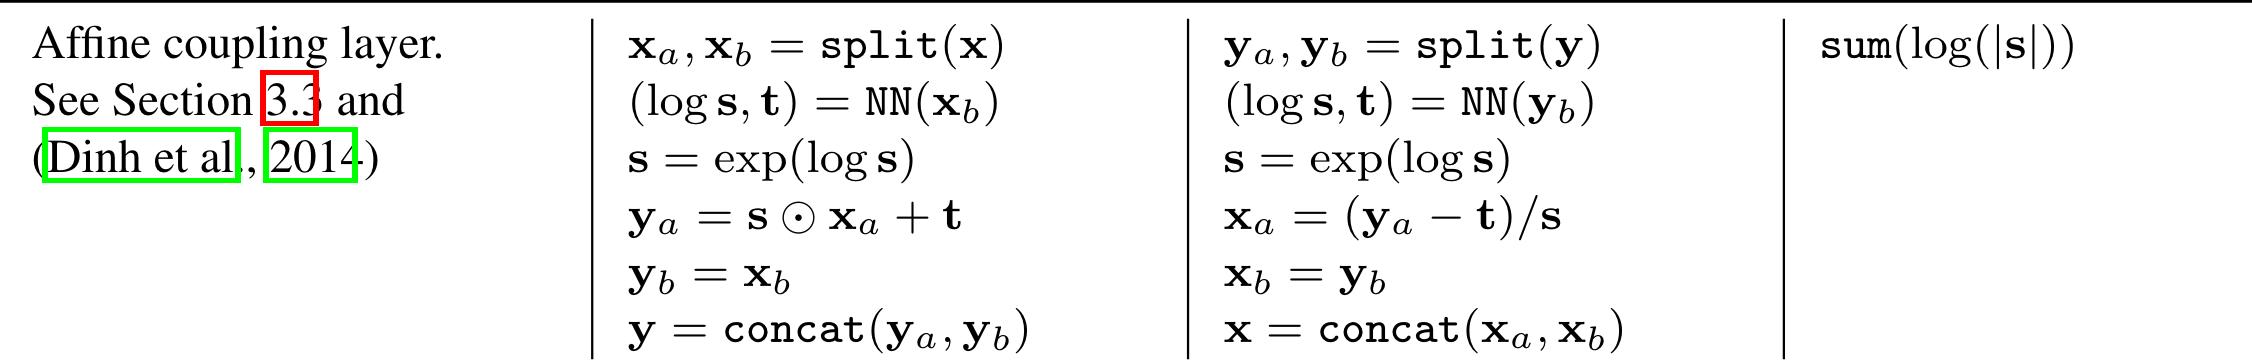

In [ ]:
class AffineCoupling(nn.Module):
    def __init__(self, n_channels):
        super(AffineCoupling, self).__init__()
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet(in_channels=n_channels//2)

    def forward(self, x):
      # Split the input in 2 channelwise
      x_a, x_b = x.chunk(2, dim=1)

      log_scale, shift = self.net(x_b).chunk(2, dim=1)
      log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale

      y_a = x_a * log_scale.exp() + shift
      y_b = x_b

      y = torch.cat([y_a, y_b], dim=1)

      return y, log_scale.sum().to(device=x.device)

    def inverse(self, y):
      y_a, y_b = y.chunk(2, dim=1)

      log_scale, shift = self.net(y_b).chunk(2, dim=1)
      log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale

      x_a = (y_a - shift) * torch.exp(-log_scale)
      x_b = y_b

      x = torch.cat([x_a, x_b], dim=1)

      return x






In [ ]:
coupling = AffineCoupling(4)
x = torch.randn(1, 4, 3, 3)

with torch.no_grad():
  z_0,_ = coupling(x)
  x_hat = coupling.inverse(z_0)
  print(torch.allclose(x, x_hat))
  print(mse(x, x_hat))



True
tensor(4.2559e-16)


### Glow Step

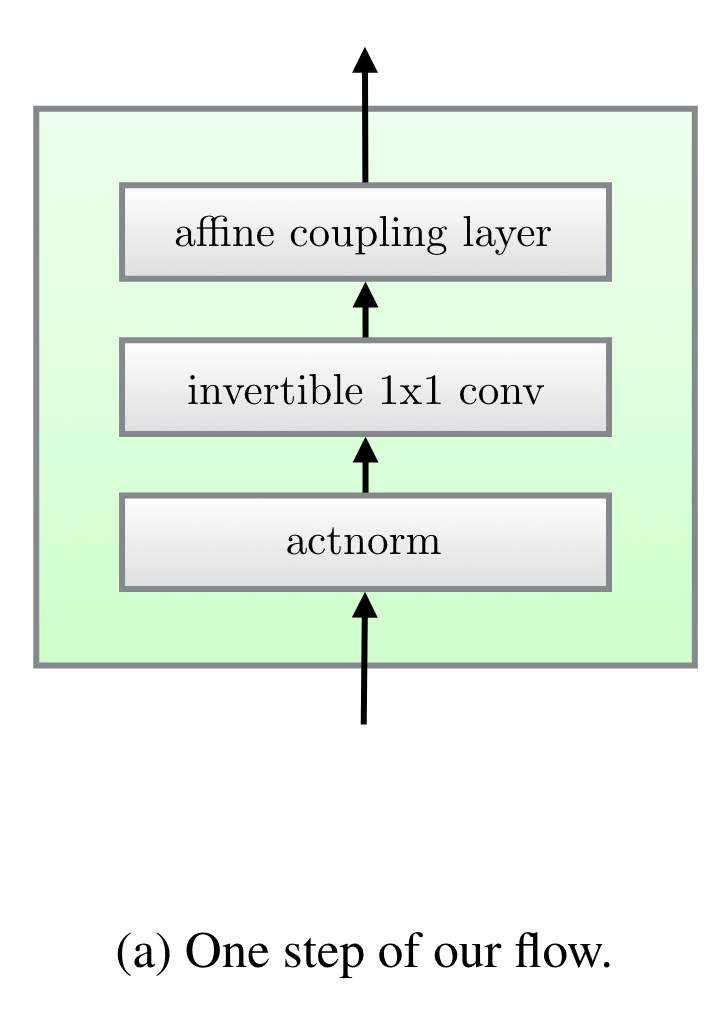

In [ ]:
class GlowStep(nn.Module):
  def __init__(self, n_channels, h, w):
    super(GlowStep, self).__init__()
    self.layers = nn.ModuleList([
        ActNorm(n_channels, 3, 3),
        Invertible1x1Conv2d(n_channels),
        AffineCoupling(n_channels),
    ])

  def forward(self, x):
    log_det_jacobian_total = torch.tensor(0.0).to(device=x.device)
    z = x

    for layer in self.layers:
      z, log_det_jacobian = layer(z)
      log_det_jacobian_total += log_det_jacobian
    return z, log_det_jacobian_total.to(device=x.device)

  def inverse(self, z):
    x = z
    for layer in self.layers[::-1]:
      x = layer.inverse(x)
    return x




### Test Glow Step


In [ ]:
step = GlowStep(6, 3, 3)
x = torch.randn(1, 6, 3, 3)
with torch.no_grad():
  z_0, jacobian = step(x)
  x_hat = step.inverse(z_0)
  assert torch.allclose(x, x_hat)
  print(mse(x,x_hat))

tensor(7.5169e-15)


### Model Definition

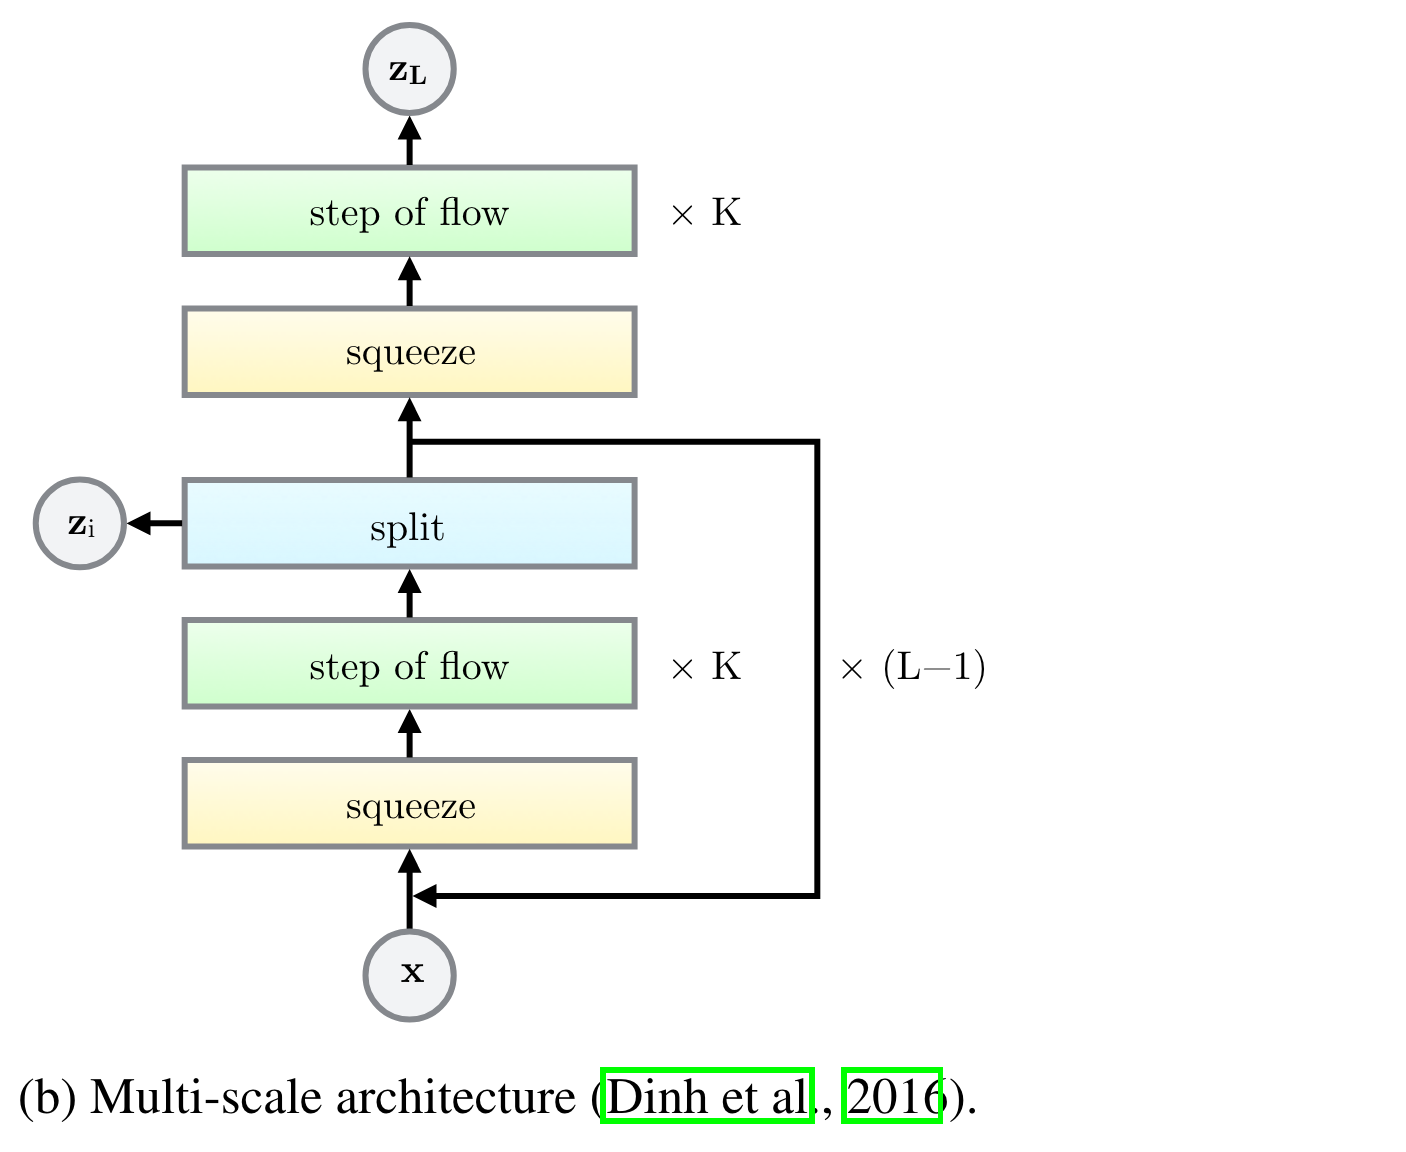

In [ ]:
class Glow(nn.Module):
  def __init__(self, n_flow_steps=3, n_flow_layers=3, n_channels=3, height=32, width=32):
    super(Glow, self).__init__()

    # self.preprocess = Preprocess()
    self.flow_layers = nn.ModuleList()


    for layer in range(1, n_flow_layers+1):
      flow_steps = nn.ModuleList()
      for _ in range(n_flow_steps):
        # print("channels:", n_channels*(4**(layer)))
        # print(height//(2*(layer)))
        # print(width//(2*(layer)))
        flow_steps.append(GlowStep(n_channels=n_channels*(4**(layer)),
                                        h=height//(2*(layer)),
                                        w=width//(2*(layer)))
        )
      self.flow_layers.append(flow_steps)



  def squeeze2d(self, x, factor=2):
    '''
    Changes the shape of x from (Batch_size, Channels, Height, Width )
    to (Batch_size, 4*Channels, Height/2, Width/2).

    x: (Tensor) input
    factor (int): how many slices to split the data
    '''

    B, C, H, W = x.shape
    assert H % factor == 0 and W % factor == 0, 'Height and Width must be divisible by factor.'

    x = x.view(B, C, H // factor, factor, W // factor, factor)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    x = x.view(B, C * (factor**2), H // factor, W // factor)
    return x

  def unsqueeze2d(self, x, factor=2):
    '''
    Reverses the Squeeze operation above.

    x: (Tensor) input
    factor (int): how many slices to split the data
    '''
    B, C, H, W = x.shape

    x = x.view(B, C // 4, factor, factor, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    x = x.view(B, C // (factor ** 2), H *factor, W * factor)
    return x


  def forward(self, x):

    log_det_jacobian_total = torch.tensor(0.0, device=x.device)
    z_i = x


    for layer in self.flow_layers:
      z_i = self.squeeze2d(z_i)
      for flow_step in layer:
        z_i, log_det_jacobian = flow_step(z_i)
        log_det_jacobian_total += log_det_jacobian


    z_0 = z_i
    for n_layers in range(len(self.flow_layers)):
      z_0 =  self.unsqueeze2d(z_0)

    # TODO come back and store the values of z_i in a matrix

    return z_0, log_det_jacobian_total



  def inverse(self, z_0):
    z_i = z_0

    for n_layers in range(len(self.flow_layers)):
      z_i =  self.squeeze2d(z_i)


    for layer in self.flow_layers[::-1]:
      for flow_step in layer[::-1]:
        z_i = flow_step.inverse(z_i)
      z_i = self.unsqueeze2d(z_i)

    x = z_i


    return x


In [ ]:
model = Glow().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
# print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 5474358


In [ ]:
x = torch.randn(1, 3, 32, 32).to(device)
with torch.no_grad():
  z_0, log_det_jacobian_total = model(x)
  x_hat = model.inverse(z_0)
  print(mse(x,x_hat))
  print(torch.allclose(x, x_hat))

tensor(6.6366e-07, device='cuda:0')
False


## Loss objective

## Log-likelihood of datapoint x
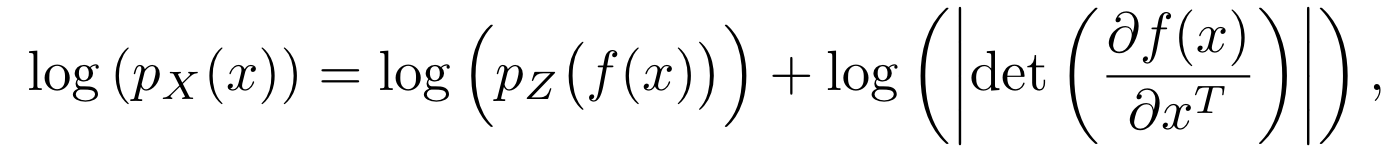



## Training Loop

# Evaluation

In [ ]:


def loss_function_Glow(target_distribution, z, log_det_jacobian):
  # print(log_det_jacobian)
  log_likelihood = target_distribution.log_prob(z).mean() + log_det_jacobian/z.shape[0]
  return -log_likelihood

from torch.distributions.normal import Normal

model.train()
target_distribution = Normal(torch.tensor(0).float().to(device),torch.tensor(1).float().to(device))
# <- You may wish to add logging info here
for epoch in range(num_epochs):
    total_loss = 0 # <- You may wish to add logging info here

    with tqdm.tqdm(trainloader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            data = data.to(device) # Need at least one batch/random data with right shape - .view(-1,28*28)
                        # This is required to initialize to model properly below
                        # when we save the computational graph for testing (jit.save)

            optimizer.zero_grad()

            # forward pass
            z, log_det_jacobian = model.forward(data)

            # compute loss
            loss = loss_function_Glow(target_distribution, z, log_det_jacobian)


            # backwards

            loss.backward()

            # update params
            optimizer.step()

            # Logging
            total_loss += loss.item()
            prior = target_distribution.log_prob(z).mean()
            jacobian = log_det_jacobian/z.shape[0]






            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item()/len(data), prior=prior, jacobian=jacobian)

    # save the model
    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                'weights/Glow_model.pth')

Epoch 0: 100%|██████████| 782/782 [00:26<00:00, 29.42batch/s, jacobian=tensor(1127.9634, device='cuda:0', grad_fn=<DivBackward0>), loss=-17.6, prior=tensor(-1.1992, device='cuda:0', grad_fn=<MeanBackward0>)]
<ipython-input-20-28e64bd53726>:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_det_jacobian_total = torch.tensor(0.0, device=x.device)
<ipython-input-20-28e64bd53726>:33: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H % factor == 0 and W % factor == 0, 'Height and Width must be divisible by facto

# Test Model

Input images
--------------------------------------------------


Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


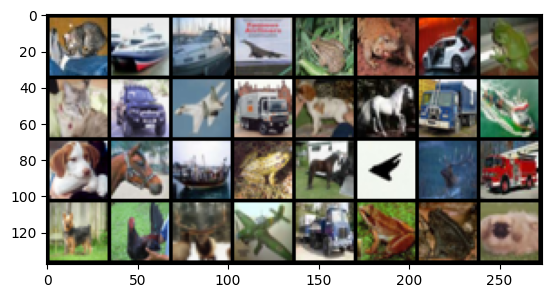

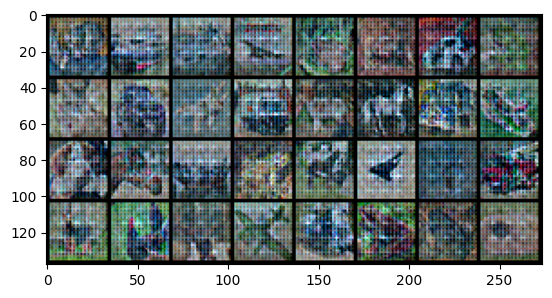

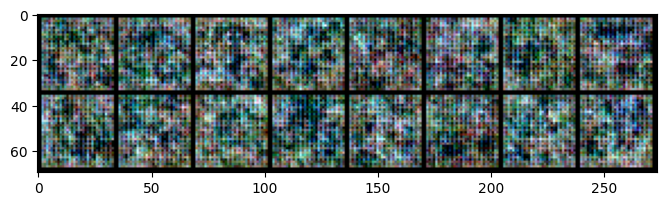

In [ ]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(testloader))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, _ = model.forward(fixed_input.to(device))
    recon_batch = model.inverse(recon_batch)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################


    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 16
z = torch.randn(n_samples, 3, 32,32).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.inverse(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)


# Scratch

log(|s|) != |log(s)|

In [ ]:
x = torch.tensor([-0.2])
y = torch.exp(x)
print(abs(torch.log(y)))

tensor([0.2000])
